In [9]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29484 sha256=c2ccb5d849feaff28efd1258942f70794b9f4d4d30e3b6f1c55be67d68f14fa3
  Stored in directory: /Users/macbookair/Library/Caches/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


[*********************100%***********************]  1 of 1 completed


Top 20 indicators by |corr| with Γ:
               |corr|
STOCH_k      0.266318
BBP_20_2.0   0.252026
ROC_10       0.166957
RSI_14       0.150589
STOCH_d      0.118623
MACD_hist    0.097153
MACD_line    0.045918
MACD_signal  0.017361
VWAP         0.011105
SMA_20       0.010818
EMA_20       0.009078
OBV          0.006801
ATR_14       0.001445

Selected indicators (|corr| ≥ 0.151):
['STOCH_k', 'BBP_20_2.0', 'ROC_10', 'RSI_14']
Fold  1  accuracy = 48.68%
Fold  2  accuracy = 49.56%
Fold  3  accuracy = 49.56%
Fold  4  accuracy = 49.12%
Fold  5  accuracy = 48.25%
Fold  6  accuracy = 45.61%
Fold  7  accuracy = 52.63%
Fold  8  accuracy = 56.58%
Fold  9  accuracy = 43.86%
Fold 10  accuracy = 46.49%

Median 10-fold CV accuracy: 4890.00%


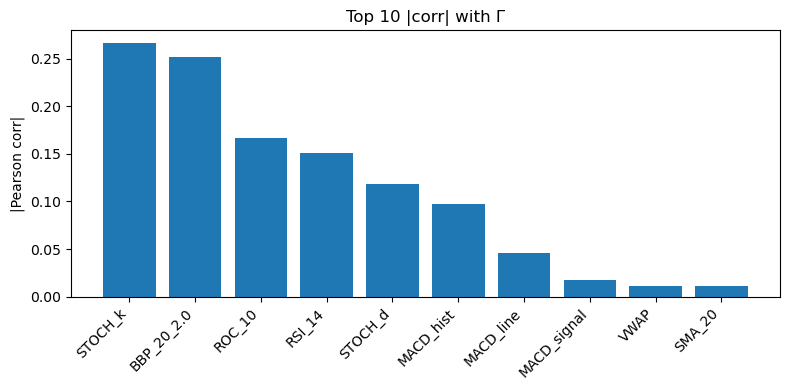

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ── 1) Download ECH OHLCV data ──────────────────────────────────────────────
data = yf.download('ECH', start='2009-12-12', end='2020-01-01')

# ── 2) Build target Γ = +1 if Open[t] > Open[t-1], else -1 ─────────────────
data['Gamma'] = np.where(data['Open'] > data['Open'].shift(1), 1, -1)

# ── 3) Compute technical indicators manually ────────────────────────────────
# Trend
df = pd.DataFrame()
df['SMA_20'] = data['Close'].rolling(20).mean()
df['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
df['MACD_line']   = ema12 - ema26
df['MACD_signal'] = df['MACD_line'].ewm(span=9, adjust=False).mean()
df['MACD_hist']   = df['MACD_line'] - df['MACD_signal']

# Momentum
delta    = data['Close'].diff()
gain     = delta.clip(lower=0)
loss     = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs       = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))
df['ROC_10'] = data['Close'].pct_change(10) * 100
low14   = data['Low'].rolling(14).min()
high14  = data['High'].rolling(14).max()
df['STOCH_k'] = (data['Close'] - low14) / (high14 - low14) * 100
df['STOCH_d'] = df['STOCH_k'].rolling(3).mean()

# Volatility
ma20   = data['Close'].rolling(20).mean()
std20  = data['Close'].rolling(20).std()
upper  = ma20 + 2 * std20
lower  = ma20 - 2 * std20
df['BBP_20_2.0'] = (data['Close'] - lower) / (upper - lower)
tr1 = data['High'] - data['Low']
tr2 = (data['High'] - data['Close'].shift(1)).abs()
tr3 = (data['Low']  - data['Close'].shift(1)).abs()
df['TR']     = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# Volume
df['OBV'] = np.sign(data['Close'].diff()) * data['Volume']
df['OBV'] = df['OBV'].cumsum()
typ_price    = (data['High'] + data['Low'] + data['Close']) / 3
df['VWAP']   = (typ_price * data['Volume']).cumsum() / data['Volume'].cumsum()

# ── 4) Lag all indicators by one day (so today's features only use info ≤ t-1) ──
# list all computed indicators
indicators = [
    'SMA_20','EMA_20',
    'MACD_line','MACD_signal','MACD_hist',
    'RSI_14','ROC_10','STOCH_k','STOCH_d',
    'BBP_20_2.0','ATR_14',
    'OBV','VWAP'
]
df[indicators] = df[indicators].shift(1)

# ── 5) Drop any rows with NaNs (warm-up + first lag) ─────────────────────────
df.dropna(inplace=True)

# ── 6) Correlation‐based selection ──────────────────────────────────────────
exclude = ['Open','High','Low','Close','Adj Close','Volume','Gamma','TR']
cands   = [c for c in df.columns if c not in exclude]
corr    = df[cands].corrwith(data['Gamma']).abs().sort_values(ascending=False)

print("Top 20 indicators by |corr| with Γ:")
print(corr.head(20).to_frame('|corr|'))

# pick the top 25 %
q75      = corr.quantile(0.75)
selected = corr[corr >= q75].index.tolist()
print(f"\nSelected indicators (|corr| ≥ {q75:.3f}):")
print(selected)

# ── 7) TimeSeriesSplit 10-fold CV with MLP ─────────────────────────────────
X = df[selected]
y = data['Gamma']
tscv = TimeSeriesSplit(n_splits=10)
fold_acc = []
for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    mlp = MLPClassifier(
        hidden_layer_sizes=((X_tr.shape[1] + 2)//2,),
        activation='logistic',
        solver='lbfgs',
        learning_rate='adaptive',
        learning_rate_init=0.03,
        max_iter=5000,
        momentum=0.2,
        random_state=42
    )
    mlp.fit(X_tr, y_tr)
    acc = accuracy_score(y_te, mlp.predict(X_te))
    fold_acc.append(100*round(acc, 4))
    print(f"Fold {fold:2d}  accuracy = {acc:.2%}")

print(f"\nMedian 10-fold CV accuracy: {np.median(fold_acc):.2%}")

# ── 8) Plot top 10 correlations ──────────────────────────────────────────────
plt.figure(figsize=(8,4))
top10 = corr.head(10)
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 |corr| with Γ')
plt.ylabel('|Pearson corr|')
plt.tight_layout()
plt.show()


In [9]:
fold_acc


[48.699999999999996,
 49.6,
 49.6,
 49.1,
 48.199999999999996,
 45.6,
 52.6,
 56.599999999999994,
 43.9,
 46.5]